In [2]:
import pandas as pd
import os
#import tiktoken
from dotenv import load_dotenv
load_dotenv()
import openai
from langchain.vectorstores import FAISS, Milvus
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chains import RetrievalQA, LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.text_splitter import CharacterTextSplitter
from langchain.document_loaders import DataFrameLoader, CSVLoader
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory

In [3]:
openai_api_key = ''
os.environ["OPENAI_API_KEY"] = openai_api_key

In [4]:
df = pd.read_csv('Dataset/Customer_Interaction_Data.csv')
df.head(10)


,Customer_ID,Product_ID,Transaction_ID,Age,Gender,Income_Bracket,Location,Engagement_Score,Discount_Sensitivity,Purchase_Date,Order_Value,Payment_Method,Repeat_Purchase_Score,Return_Rate,Session_ID,Time_Spent_Per_Product,Purchase_Probability_Score
0,CUST1001,PROD2601,TXN645944,23.0,Male,Low Income,Bali,0.48,0.25,2021-08-06 09:57:07,1507956.74,Cash,0.41,0.03,SESSION416779,157.64,0.58
1,CUST1001,PROD4037,TXN250056,23.0,Male,Low Income,Bali,0.31,0.55,2020-05-05 11:40:18,1081582.40,E-Wallet,0.16,0.20,SESSION899312,146.97,0.09
2,CUST1001,PROD2692,TXN993426,23.0,Male,Low Income,Bali,1.00,0.58,2022-01-29 16:40:26,2439574.65,Credit Card,0.15,0.30,SESSION946744,284.64,0.23
3,CUST1002,PROD2504,TXN619556,59.0,Other,High Income,Surabaya,0.11,0.73,2020-05-08 17:13:26,154000.53,E-Wallet,0.82,0.07,SESSION748067,65.03,0.07
4,CUST1003,PROD3598,TXN941863,41.0,Male,High Income,Jakarta,0.91,0.84,2020-07-11 16:34:50,1846396.78,Cash,0.56,0.33,SESSION582839,139.87,0.07
5,CUST1004,PROD4247,TXN296189,34.0,Male,Low Income,Surabaya,1.00,0.87,2022-07-10 09:01:02,2590155.31,E-Wallet,0.86,0.20,SESSION891950,234.27,0.17
6,CUST1004,PROD3515,TXN560526,34.0,Male,Low Income,Surabaya,0.52,0.35,2022-07-28 18:37:09,1019052.59,Credit Card,0.98,0.06,SESSION107029,136.52,0.94
7,CUST1007,PROD4687,TXN286040,26.0,Female,Middle Income,Bandung,0.63,0.73,2023-04-12 06:36:59,252720.43,Cash,0.68,0.34,SESSION573954,6.67,0.85
8,CUST1007,PROD1071,TXN985265,26.0,Female,Middle Income,Bandung,0.70,0.43,2024-02-15 03:25:42,2174970.90,Cash,0.73,0.02,SESSION523925,263.77,0.14
9,CUST1011,PROD1762,TXN651392,53.0,Female,Middle Income,Surabaya,0.19,0.45,2022-08-13 07:11:22,2648141.97,Credit Card,0.58,0.29,SESSION762872,80.59,0.34


In [5]:
df_products = pd.read_csv('Dataset/url_local_product_1601-3200.csv')
df_products.head()

,Product_ID,Category,Size,Color,Price,Rating,Launch_Date,Trending_Score,Weather,Event_Type,Url_Image
0,PROD2488,Coat,XL,Red,670167.90,4.92,2020-08-27,0.23,Cloudy,Sports Event,Final Product 1602-3201/PROD2488.jpg
1,PROD2445,Dress,M,Black,2540654.63,3.03,2021-12-01,0.73,Rainy,Wedding,Final Product 1602-3201/PROD2445.jpg
2,PROD1212,Coat,XXL,Green,1770812.27,3.77,2024-01-18,0.29,Snowy,Sports Event,Final Product 1602-3201/PROD1212.jpg
3,PROD3805,Jacket,L,Red,1551166.83,4.71,2023-11-11,0.42,Cloudy,Business Meeting,Final Product 1602-3201/PROD3805.jpg
4,PROD3212,Suit,S,White,1831197.93,3.52,2022-09-07,0.37,Sunny,Business Meeting,Final Product 1602-3201/PROD3212.jpg


In [5]:
# for similarity search product catalog
df_products["combined_info"] = df_products.apply(
    lambda row: f"Product ID: {row['Product_ID']}. Category: {row['Category']}. Size: {row['Size']}. Color: {row['Color']}. Price: {row['Price']}. Rating: {row['Rating']}. Launch Date: {row['Launch_Date']}. Trending Score: {row['Trending_Score']}. Weather: {row['Weather']}. Event Type: {row['Event_Type']}",
    axis=1)

## Add product details to customer interaction data

In [6]:
# product_details = df_products.apply(
#     lambda row: f"A {row['Category']} with {row['Size']} size and {row['Color']} color. Suitable in {row['Weather']} and for {row['Event_Type']}. The price of this item is {row['Price']} with {row['Rating']} rating. Launched at {row['Launch_Date']} and has {row['Trending_Score']} trending score.",
#     axis=1)

In [7]:
# df_details = pd.concat([df_products["Product_ID"], product_details], axis=1)
# df_details.rename(columns={0: "Product Details"}, inplace=True)
# df_details.head()

In [8]:
# df_merged = pd.merge(df, df_details, on='Product_ID')
# df_merged.head()

In [9]:
# file_path = "Customer_Interaction_Data_v2.csv"
# df_merged.to_csv(file_path, index=False)

# Begin

In [10]:
# load to dataframeloader

loader = DataFrameLoader(df_products, page_content_column="combined_info")
docs  = loader.load()

In [11]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts = text_splitter.split_documents(docs)

In [12]:
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)

# Vector DB
vectorstore  = FAISS.from_documents(texts, embeddings)

C:\Users\User\AppData\Local\Temp\ipykernel_8112\598696696.py:1: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)


ImportError: Could not import faiss python package. Please install it with `pip install faiss-gpu` (for CUDA supported GPU) or `pip install faiss-cpu` (depending on Python version).

In [13]:
# product retriever to retrieve based on product catalog
product_retriever = vectorstore.as_retriever()

NameError: name 'vectorstore' is not defined

In [6]:
# CSV tool (not the one from vectorstore)
from crewai_tools import BaseTool, CSVSearchTool

csv_search_tool_history = CSVSearchTool("/content/Customer_Interaction_Data.csv")
csv_search_tool_product = CSVSearchTool("/content/url_product_1601-3200.csv")

Inserting batches in chromadb: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


In [7]:
# tool to retrieve purchased history

from crewai_tools import BaseTool, CSVSearchTool
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_csv_agent
from langchain_openai import ChatOpenAI, OpenAI
from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "Use the given context to answer the question. "
    "If you don't know the answer, say you don't know. "
    "Accept context that shows about data, besides that say that the context is prohibited. "
    "Give detailed answer, but don't make it a table. "
    "Use this following format: "
    "   Purchased history: "
        "- Customer ID: "
        "- Product ID: "
        "- Transaction ID: "
        "- Purchase Date: "
        "- Order Value: "
        "- Product Details: "
    "Context: {context}"
)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{context}"),
    ]
)

csv_agent = create_csv_agent(
    ChatOpenAI(temperature=0, model="gpt-3.5-turbo"),
    "/content/Customer_Interaction_Data.csv",
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
    allow_dangerous_code=True,
    prompt=prompt
)

class PurchaseHistoryInfo(BaseTool):
    name: str = "Purchase History Information Tool"
    description: str = "Search past history based on specific task and customer"

    def _run(self, query: str) -> str:
        return csv_agent.run(query)

FileNotFoundError: [Errno 2] No such file or directory: '/content/Customer_Interaction_Data.csv'

In [8]:
# tool to retrieve product from query

class ProductCatalogTool(BaseTool):
  name:str = "Product Catalog Information Tool"
  description: str = "Search product catalog based on query."

  def _run(self, query: str) -> str:

    chatbot_template = """
    You are a friendly, conversational retail shopping assistant that help customer to find product that match their preferences.
    From the following context, assist them in finding what they are looking for based on their input.
    For each question, suggest maximum three products, including their product_ID, category, price, size, color, weather, event type, and the reason.
    Make sure the reason is based on their preference.
    Sort the answer by the cheapest product.
    If you don't know the answer, just say that you don't know, don't try to make up an answer.

    {context}

    chat history: {history}

    input: {question}
    Your Response:
    """
    chatbot_prompt = PromptTemplate(
        input_variables=["context","history","question"],
        template=chatbot_template,
      )

    # Create the LangChain conversational chain
    memory = ConversationBufferMemory(memory_key="history", input_key="question", return_messages=True)

    llm = ChatOpenAI(openai_api_key=openai_api_key,model_name='gpt-3.5-turbo', temperature=0)

    qa = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type='stuff',
        retriever=vectorstore.as_retriever(search_kwargs={"k": 5}),
        verbose=True,
        chain_type_kwargs={
            "verbose": True,
            "prompt": chatbot_prompt,
            "memory": memory,
            }
      )

    return qa.run(query)

In [10]:
from crewai.agent import Agent
from crewai.task import Task
from crewai.crew import Crew
from crewai import Process

llm = ChatOpenAI(openai_api_key=openai_api_key,model_name='gpt-3.5-turbo', temperature=0.1)
#tools=[PurchaseHistoryInfo()]

# agent to retrieve purchase history

purchase_history_retriever_agent = Agent(
    role='Purchase history retriever',
    goal='Find the purchase history specifically for the {customer}.',
    backstory=(
        "You are a meticulous Purchase History Retrieval working at Fashion company "
        "ensuring accurate and up-to-date data gotten from the database. "
        "is available for solving customers queries."
        "You need to make sure that the data is relevant and accurate."
        "Prodive the Customer_ID, Product_ID, Transaction_ID, Purchase_Date, Order_Value, and Product_Details."
        ),
    llm=llm,
    verbose=True,
    allow_delegation=True,
    tools=[csv_search_tool_history]
)




In [11]:
#agent to retrieve products
#tools2=[ProductCatalogTool()]
product_catalog_retriever_agent = Agent(
    role='Product Catalog Retriever',
    goal='Find the related product based on customer task: {query}',
    backstory=(
        "You are working on a task: {query} to provide the customer. "
        "Retrieve the specific output from the specific task: {query}. Provide the list of products, including Product_ID, Rating, Category, Size, Color, Price, Weather, and Event Type."
        "You need to make sure that the data is relevant and accurate. "
        "Provide with at least 5 products."
    ),
    llm=llm,
    verbose=True,
    allow_delegation=True,
    tools=[csv_search_tool_product]
)


In [12]:
review_agent = Agent(
    role='Result Reviewer',
    goal="Review the response drafted by the Purchase history retriever and Product Catalog Retriever for {customer}'s inquiry: {query}. ",
    backstory=(
        "You are working on a task: {query} to provide the customer. "
        "Review the response drafted by the Purchase history retriever and Product Catalog Retriever for {customer}'s inquiry: {query}. "
    ),
    llm=llm,
    verbose=True
)

In [13]:
llm_product_recommender = ChatOpenAI(openai_api_key=openai_api_key,model_name='gpt-4o-mini', temperature=0.1)
product_recommender_agent = Agent(
    role='Product Recommendation Provider',
    goal="Give product recommendation based on review from Result Reviewer. ",
    backstory=(
        "You are working on a task: {query} to give product recommendation. "
        "Analyze the product details from customer purchase history and product catalog. "
        "Find the correlation between them to provide best product recommendation. "
    ),
    llm=llm_product_recommender,
    verbose=True
)

In [14]:
# quality_assurance_agent = Agent(
#     role="Support Quality Assurance Specialist",
#     goal="Get recognition for providing the "
#     "best support quality assurance in your team",
#     backstory=(
# 		"You are working with your team "
# 		"on a request from {customer} ensuring that "
#         "the Purchase history retriever is "
# 		"providing the best support possible.\n"
# 		"You need to make sure that the Purchase history retriever "
#         "is providing full"
# 		"complete answers, and make no assumptions."
# 	),
#     verbose=True
# )

In [15]:
# purchase history task
retrieve_purchase_history_task = Task(
    description=(
        "Gather all relevant {customer} data from the dataset, focusing "
        "on crucial data which will be great to know when addressing the "
        "customer's inquiry."
        "Give accurate answer and no assumption. Return '{customer} is not available' if the customer is not in the dataset."
        ),
    expected_output=("A list of the customer's information. "
      "Turn them into bullets. "
      "Highlighting key info of the customer that will be helpful "
      "to the team when addressing the customer's query. "
    ),
    agent=purchase_history_retriever_agent
)

In [16]:
#product catalog task
retrieve_product_catalog_task = Task(
    description=("customer is asking for specific task: {query}. "
      "Analyze the Product_Catalog_Data.csv and make sure the task from customer is answered accurately. "
      "Make sure that you provide the best and relevant answer. "
      "Give accurate answer and no assumption."
      "Use 'search_query: {query}' for tool input."
    ),
    expected_output=("List of 5 product(s) with product ID that match user task."
    ),
    agent=product_catalog_retriever_agent,
)

In [17]:
review_result_task = Task(
    description=(
        "Review the purchase history from Purchase History Retriever and the products"
        "from Product Catalog Retriever."
    ),
    expected_output=(
        "List all of received purchase history from Purchase History Retriever with following format: "
        "1. Purchased history: "
        "- Customer ID: "
        "- Product ID: "
        "- Transaction ID: "
        "- Purchase Date: "
        "- Order Value: "
        "and list of prodcut from Product Catalog Retriever with following format: "
        "2. Product Catalog: "
    ),
    agent=review_agent,
    context=[retrieve_purchase_history_task, retrieve_product_catalog_task]
)

In [18]:
product_recommendation_task = Task(
    description=(
        "Analyze the product details from user purchase history and product catalog received only from Result Reviewer "
        "to give best product recommendation to user."
        "You are not allowed to search any product besides from Result Reviewer."
    ),
    expected_output=(
        "List of maximum 3 product recommendation after find the similarity or relevance between  product details from user purchase history and product catalog from Result Reviewer. "
        "Give the reason to convince customer. "
        "Do not make any assumption, just based on received user purchase history and product catalog. "
        "If the product is not available, return that the product is not in product catalog."
    ),
    agent=product_recommender_agent,
    context=[review_result_task]
)

In [19]:
import re
class ProductImageTool(BaseTool):
  name:str = "Product Recommendation image Tool"
  description: str = "Provide recommendation Image"
  #df_products = pd.read_csv('/content/url_product_1601-3200.csv')

  def get_product_id(self, context):
    output = context.raw
    # Regular expression pattern to extract Product ID
    pattern = r"\*\*Product ID: (?P<product_id>\w+)\*\*"
    # Extract all matches
    product_ids = re.findall(pattern, output)
    return product_ids

  def _run(self, context:str) -> str:
    df_products = pd.read_csv('/content/url_product_1601-3200.csv')
    product_ids = self.get_product_id(context)
    urls = []
    for i in product_ids:
      url = df_products[df_products['Product_ID'] == i]['Url_Image'].iloc[0]
      urls.append(url)
    return urls

In [20]:

llm_product_recommender = ChatOpenAI(openai_api_key=openai_api_key,model_name='gpt-4o-mini', temperature=0.1)
product_image_recommender_agent = Agent(
    role='Product Recommendation With Image',
    goal="Give product recommendation with image based on review from Product Recommendation Provider. ",
    backstory=(
        "You are working on a task: {query} to give product recommendation with image. "
        "Analyze the product details from customer purchase history and product catalog. "
        "Find the correlation between them to provide best product recommendation. "
    ),
    tools = [ProductImageTool()],
    llm=llm_product_recommender,
    verbose=True
)

In [21]:
product_recommendation_image_task = Task(
    description=(
        "Analyze the product details from user purchase history and product catalog received only from Product Recommendation Provider "
        "to give best product recommendation with image to user."
        "You are not allowed to search any product besides from Product Recommendation Provider."
    ),
    expected_output=(
        "List of maximum 3 product recommendation after find the similarity or relevance between  product details from user purchase history and product catalog from Result Reviewer. "
        "Give the reason to convince customer. "
        "Do not make any assumption, just based on received user purchase history and product catalog. "
        "If the product is not available, return that the product is not in product catalog."
    ),
    agent=product_image_recommender_agent,
    context=[product_recommendation_task]
)

In [22]:
crew = Crew(
    agents=[purchase_history_retriever_agent, product_catalog_retriever_agent, review_agent, product_recommender_agent],
    tasks=[retrieve_purchase_history_task, retrieve_product_catalog_task, review_result_task, product_recommendation_task],
    verbose=True,
)

In [23]:
# customer = "CUST1002"
# query = "What product did i buy?"

# inputs = {
#     "query": {
#         "description": query + f" Customer ID: {customer}",
#         "type": "str"
#     },
#     "customer": customer
# }

# result = crew.kickoff(inputs=inputs)


In [24]:
product_retriever.get_relevant_documents("shirt for winter in XL size")

NameError: name 'product_retriever' is not defined

In [32]:
customer = "CUST1012"
query = " Shirt yellow for vacation"

inputs = {
    "query":  query,
    "customer": customer
}

if customer not in df["Customer_ID"].values:
  print("Customer is not available")
else:
  result = crew.kickoff(inputs=inputs)

# Agent: Purchase history retriever
## Task: Gather all relevant CUST1012 data from the dataset, focusing on crucial data which will be great to know when addressing the customer's inquiry.Give accurate answer and no assumption. Return 'CUST1012 is not available' if the customer is not in the dataset.


# Agent: Purchase history retriever
## Thought: I need to search the dataset for the purchase history of CUST1012 to gather all relevant information for the customer's inquiry.
## Using tool: Search a CSV's content
## Tool Input: 
"{\"search_query\": \"CUST1012\"}"
## Tool Output: 
Relevant Content:
Customer_ID: CUST7212, Product_ID: PROD2736, Transaction_ID: TXN988429, Age: 52.0, Gender: Female, Income_Bracket: Low Income, Location: Surabaya, Engagement_Score: 0.5, Discount_Sensitivity: 0.51, Purchase_Date: 2020-12-17 06:47:24, Order_Value: 2254102.52, Payment_Method: Credit Card,

Customer_ID: CUST6912, Product_ID: PROD5222, Transaction_ID: TXN163429, Age: 63.0, Gender: Female, Income

In [33]:
from IPython.display import Markdown
Markdown(result.raw)

Based on the analysis of your purchase history and the product catalog, here are the top three product recommendations for a yellow shirt suitable for vacation:

1. **Product ID: PROD4075**
   - **Rating:** 4.97
   - **Category:** Shirt
   - **Size:** M
   - **Color:** Yellow
   - **Price:** 109545.8
   - **Weather:** Sunny
   - **Event Type:** Vacation
   - **Reason:** This shirt has an excellent rating of 4.97, indicating high customer satisfaction. It is specifically designed for sunny weather and vacation events, making it a perfect match for your needs. The price is also reasonable compared to other options.

2. **Product ID: PROD4224**
   - **Rating:** 3.79
   - **Category:** Shirt
   - **Size:** M
   - **Color:** Yellow
   - **Price:** 2933066.07
   - **Weather:** Sunny
   - **Event Type:** Vacation
   - **Reason:** Although this shirt has a lower rating of 3.79, it is still a viable option for your vacation. It is also designed for sunny weather and is in the same color and category as your previous purchase, ensuring a consistent style.

3. **Product ID: PROD1290**
   - **Rating:** 3.79
   - **Category:** Shirt
   - **Size:** XXL
   - **Color:** Yellow
   - **Price:** 1292227.18
   - **Weather:** Sunny
   - **Event Type:** Vacation
   - **Reason:** This shirt is another option with a rating of 3.79. While it is available in a larger size (XXL), it still meets the criteria of being yellow and suitable for sunny vacation events. This could be a good choice if you prefer a looser fit.

These recommendations are tailored to your previous purchase and the current catalog offerings, ensuring you find the perfect yellow shirt for your vacation.

In [34]:
print(result)

Based on the analysis of your purchase history and the product catalog, here are the top three product recommendations for a yellow shirt suitable for vacation:

1. **Product ID: PROD4075**
   - **Rating:** 4.97
   - **Category:** Shirt
   - **Size:** M
   - **Color:** Yellow
   - **Price:** 109545.8
   - **Weather:** Sunny
   - **Event Type:** Vacation
   - **Reason:** This shirt has an excellent rating of 4.97, indicating high customer satisfaction. It is specifically designed for sunny weather and vacation events, making it a perfect match for your needs. The price is also reasonable compared to other options.

2. **Product ID: PROD4224**
   - **Rating:** 3.79
   - **Category:** Shirt
   - **Size:** M
   - **Color:** Yellow
   - **Price:** 2933066.07
   - **Weather:** Sunny
   - **Event Type:** Vacation
   - **Reason:** Although this shirt has a lower rating of 3.79, it is still a viable option for your vacation. It is also designed for sunny weather and is in the same color and cat

In [35]:
import re
output = result.raw
# Regular expression pattern to extract Product ID
pattern = r"\*\*Product ID: (?P<product_id>\w+)\*\*"
# Extract all matches
product_ids = re.findall(pattern, output)
product_ids

['PROD4075', 'PROD4224', 'PROD1290']

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

display(Markdown(output))
for i in product_ids:
  url = df_products[df_products['Product_ID'] == i]['Url_Image'].iloc[0]
  img = mpimg.imread(url)

  # Menampilkan gambar
  print(i)
  plt.imshow(img)
  plt.axis('off')  # Menyembunyikan axis
  plt.show()
  print("Buy")
  print("Virtual Try Ons")
  print("--------------------------------------------------------------------------------")


ModuleNotFoundError: No module named 'matplotlib'

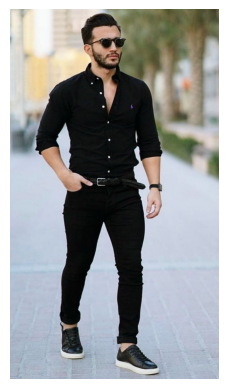

**Product ID: PROD3115**  
   - **Rating:** 4.67  
   - **Size:** XXL  
   - **Color:** Black  
   - **Price:** 487529.44  
   - **Weather:** Sunny  
   - **Event Type:** Casual Hangout  
   **Reason:** This shirt has a high rating of 4.67, indicating strong customer satisfaction. It is specifically designed for casual hangouts, making it an excellent choice for socializing with friends. The sunny weather suitability adds to its versatility for outdoor gatherings.

2. 

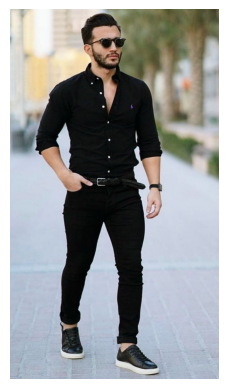

**Product ID: PROD3363**  
   - **Rating:** 4.59  
   - **Size:** XXL  
   - **Color:** Black  
   - **Price:** 867599.2  
   - **Weather:** Cloudy  
   - **Event Type:** Casual Hangout  
   **Reason:** With a rating of 4.59, this shirt also boasts a solid reputation among customers. It is perfect for casual hangouts and is suitable for cloudy weather, ensuring comfort regardless of the conditions. The stylish design and quality make it a great addition to your wardrobe.

3. 

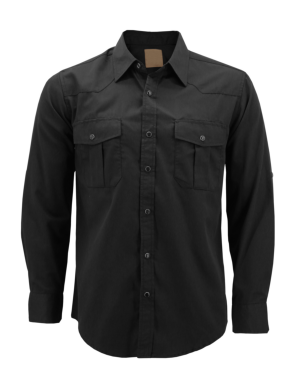

**Product ID: PROD2788**  
   - **Rating:** 3.85  
   - **Size:** L  
   - **Color:** Black  
   - **Price:** 1113752.7  
   - **Weather:** Snowy  
   - **Event Type:** Casual Hangout  
   **Reason:** Although this shirt has a slightly lower rating of 3.85, it is still a viable option for casual hangouts. Its design is suitable for snowy weather, which may appeal to those who enjoy winter outings with friends. The price reflects its quality and style, making it a worthwhile consideration.

These recommendations are tailored to your preferences for black shirts and are ideal for casual hangouts with friends.

In [ ]:
# Loop melalui product_ids untuk menampilkan gambar dan detail produk
for product_id in product_ids:
    # Ambil URL gambar
    url = df_products[df_products['Product_ID'] == product_id]['Url_Image'].iloc[0]

    # Ekstrak detail produk untuk Product ID saat ini
    product_details_pattern = rf"\*\*Product ID: {product_id}\*\*.*?(?=\*\*Product ID:|\Z)"
    product_details = re.search(product_details_pattern, output, re.DOTALL).group(0)

    # Tampilkan gambar
    img = mpimg.imread(url)
    plt.imshow(img)
    plt.axis('off')  # Sembunyikan sumbu
    plt.show()

    # Tampilkan detail produk
    display(Markdown(product_details))